In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.utils.data as data_utils
from torch.autograd import Variable
import torchvision.datasets as dsets
import math
import torchvision.models as models
from PIL import Image
from deepfool import deepfool
import os,sys
from FGSM import fgsm,fgsm_graybox
from train_mnist_model import Net
from tqdm import tqdm
from torch.distributions.categorical import Categorical

homedir = '/home/nikhil/research/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'
# homedir = '/home/serge/Documents/Classes/Adversarial_ML/Examining-Robustness-of-BNNs-to-Adversarial-Examples/'
MODULE_PATH = ['{}BNN_Implementations/PyTorch-BayesianCNN-master'.format(homedir),
          '{}BNN_Implementations/PyTorch-BayesianCNN-master/models/BayesianModels'.format(homedir)]

for m in MODULE_PATH:
    sys.path.append(m)

import data
from BayesianLeNet import BBBLeNet
import metrics
from utils import *
from models.NonBayesianModels.LeNet import LeNet

In [2]:
# %env CUDA_DEVICE_ORDER=PCI_BUS_ID
# %env CUDA_VISIBLE_DEVICES=0

In [3]:
dataset = 'MNIST'
# dataset = 'FashionMNIST'
# dataset = 'CIFAR10'
# net = 'alexnet'
net = 'lenet'

batch_size=1000
valid_size = 0.2 # will not be used 
num_workers = 0

trainset, testset, inputs, outputs = data.getDataset(dataset)
train_loader, valid_loader, test_loader = data.getDataloader(trainset, testset, valid_size, 
                                                             batch_size, num_workers)


In [4]:
def bayes_marginalization(net, inputs, J=10):
    
    outputs = torch.zeros(inputs.shape[0], net.num_classes, J).to(device)
    kl = 0.0

    for j in range(J):
        net_out, _kl = net(inputs)
        kl += _kl
        outputs[:, :, j] = F.log_softmax(net_out, dim=1).data
    
    log_outputs = logmeanexp(outputs, dim=2)
    return log_outputs, kl

def bayes_evaluation(net, criterion, validloader, num_ens=100):
    """Calculate ensemble accuracy and NLL Loss"""

    net.train(True)
    
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
                
        log_outputs, kl = bayes_marginalization(net, inputs, num_ens)
        valid_loss += criterion(log_outputs, labels, kl).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)

def frequentist_evaluation(net, criterion, valid_loader):
    
    valid_loss = 0.0
    accs = []
    net.eval()
    for data, target in valid_loader:
        data, target = data.to(device), target.to(device)
        output = net(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
        accs.append(metrics.acc(output.data, target))

    return valid_loss, accs

In [5]:
def attack_fgsm(model,loss,eps,device,loader,is_bayes=False):
    original_preds_soft = []
    attack_preds_soft = []
    
    for batch_idx, (images, labels) in enumerate(loader):
        
        attack_images = fgsm(model=model,loss=loss,device=device,images=images,labels=labels,eps=eps,is_bayes=is_bayes)
        
        if is_bayes:
            original_preds_soft.append(model(images.to(device))[0].detach())
            attack_preds_soft.append(model(attack_images)[0].detach())
        else:
            original_preds_soft.append(model(images.to(device)).detach())
            attack_preds_soft.append(model(attack_images).detach())
        
    original_preds_soft = torch.cat(original_preds_soft, dim=0)
    attack_preds_soft = torch.cat(attack_preds_soft,dim=0)
    original_preds = torch.argmax(original_preds_soft,axis=1)
    attack_preds = torch.argmax(attack_preds_soft,axis=1)
    
    success_rate = torch.mean((original_preds!=attack_preds).type(torch.DoubleTensor)).cpu().detach().numpy()
    entropy = np.mean(Categorical(probs = F.softmax(attack_preds_soft,dim=0)).entropy().cpu().detach().numpy())
    
    return success_rate,entropy

In [6]:
def attack_fgsm_v2 (model,loss,eps,device,loader,is_bayes=False):
    
    attack_preds_soft = []
    attack_acc = []
    
    for batch_idx, (images, labels) in enumerate(loader):
        
        attack_images = fgsm(model=model,loss=loss,device=device,images=images,labels=labels,eps=eps,is_bayes=is_bayes)
        
        if is_bayes:
            log_outputs, _ = bayes_marginalization(model, attack_images, J=100)
            attack_preds_soft.append(log_outputs)
            attack_acc.append(metrics.acc(log_outputs, labels))
        else:
            outputs = model(attack_images).detach()
            attack_preds_soft.append(outputs)
            attack_acc.append(metrics.acc(outputs, labels))

    attack_preds_soft = torch.cat(attack_preds_soft,dim=0)
    attack_preds = torch.argmax(attack_preds_soft,axis=1)

    if is_bayes:
        entropy = np.mean(Categorical(probs = torch.exp(attack_preds_soft)).entropy().cpu().detach().numpy())
    else:
        entropy = np.mean(Categorical(probs = F.softmax(attack_preds_soft,dim=0)).entropy().cpu().detach().numpy())
    
    return np.mean(attack_acc), entropy, attack_images, images


# Example attack on a non-Bayes CNN (MNIST)

In [7]:
dataset, inputs, outputs

('MNIST', 1, 10)

In [8]:
from main_frequentist import getModel
model = getModel(net, inputs, outputs)

In [9]:
# model = LeNet(num_classes=10,inputs=inputs)
ckpt_path = '../../BNN_Implementations/PyTorch-BayesianCNN-master/checkpoints/{}/frequentist/model_{}.pt'.format(dataset, net)
model.load_state_dict(torch.load(ckpt_path))
model.eval()
device = torch.device('cuda:0')
model.to(device)
loss = nn.CrossEntropyLoss()

In [10]:
original_loss, original_acc = frequentist_evaluation(model, loss, test_loader)

In [11]:
print (np.mean(original_acc))

0.9841000000000001


In [12]:
for ix, (_, labels) in enumerate(test_loader):
    if (ix == len(test_loader)-1):
        m = labels.data.numpy()

In [13]:
indices = []

for ix in range(10):
    indices.append(np.where(m == ix)[0][0])

In [14]:
indices

[4, 2, 6, 7, 8, 13, 1, 0, 20, 23]

In [15]:
if dataset == 'CIFAR10':
    epsilons = np.linspace(0,0.1,40)
else:
    epsilons = np.linspace(0,0.5,20)
    
acc = []
entropies = []

# indices = np.random.choice(len(test_loader), 10)
freq_attack_images_arr = []
freq_original_images_arr = []

for eps in tqdm(epsilons):
    success_rate,entropy, attack_images, original_images = attack_fgsm_v2(model,loss,eps,device,test_loader)

    freq_attack_images_arr.append(attack_images[indices].cpu().data)
    freq_original_images_arr.append(original_images[indices].cpu().data)
    
    acc.append(success_rate)
    entropies.append(entropy)


100%|██████████| 20/20 [00:25<00:00,  1.30s/it]


Text(0, 0.5, 'Average predictive entropy')

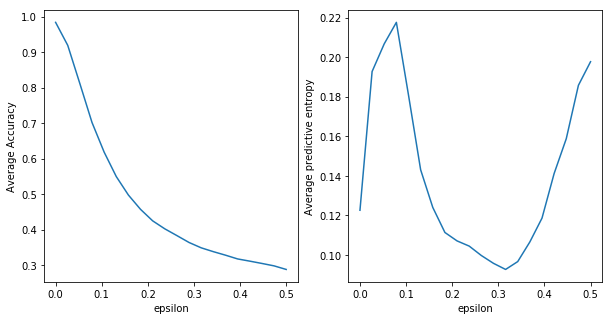

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc)
plt.xlabel('epsilon')
plt.ylabel('Average Accuracy')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

# Example attack on BayesNet

In [17]:
from main_bayesian import getModel
model = getModel(net, inputs, outputs)

In [18]:
# model = BBBLeNet(outputs=10,inputs=inputs)

ckpt_path = 'BNN_Implementations/PyTorch-BayesianCNN-master/checkpoints/{}/bayesian'.format(dataset)
ckpt_name = 'model_{}.pt'.format(net)
model.load_state_dict(torch.load(os.path.join(homedir,ckpt_path,ckpt_name)))
device = torch.device('cuda:0')
model.to(device)
loss = metrics.ELBO(len(test_loader.dataset)).to(device)

In [19]:
# model.train(True) => for sampling
model.training

True

In [20]:
original_loss, original_acc =  bayes_evaluation(model, loss, test_loader)

/media/bigguy/nm208/torch3/lib/python3.5/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [21]:
print (np.mean(original_acc))

0.9804999999999999


In [22]:
np.linspace(0, 0.1, 20), dataset

(array([0.        , 0.00526316, 0.01052632, 0.01578947, 0.02105263,
        0.02631579, 0.03157895, 0.03684211, 0.04210526, 0.04736842,
        0.05263158, 0.05789474, 0.06315789, 0.06842105, 0.07368421,
        0.07894737, 0.08421053, 0.08947368, 0.09473684, 0.1       ]), 'MNIST')

In [23]:
if dataset == 'CIFAR10':
    epsilons = np.linspace(0,0.1,40)
else:
    epsilons = np.linspace(0,0.5,20)
    
acc_bayes = []
entropies_bayes = []

bayes_attack_images_arr = []
# bayes_original_images_arr = []

for eps in tqdm(epsilons):
    success_rate, entropy, attack_images, original_images = attack_fgsm_v2(model,loss,eps,device,test_loader,is_bayes=True)
    
    bayes_attack_images_arr.append(attack_images[indices].cpu().data)
#     original_images_arr.append(original_images[indices].cpu().data)
    
    acc_bayes.append(success_rate)
    entropies_bayes.append(entropy)

100%|██████████| 20/20 [01:19<00:00,  3.96s/it]


In [24]:
print (epsilons)

[0.         0.02631579 0.05263158 0.07894737 0.10526316 0.13157895
 0.15789474 0.18421053 0.21052632 0.23684211 0.26315789 0.28947368
 0.31578947 0.34210526 0.36842105 0.39473684 0.42105263 0.44736842
 0.47368421 0.5       ]


In [25]:
print (len(bayes_attack_images_arr))

20


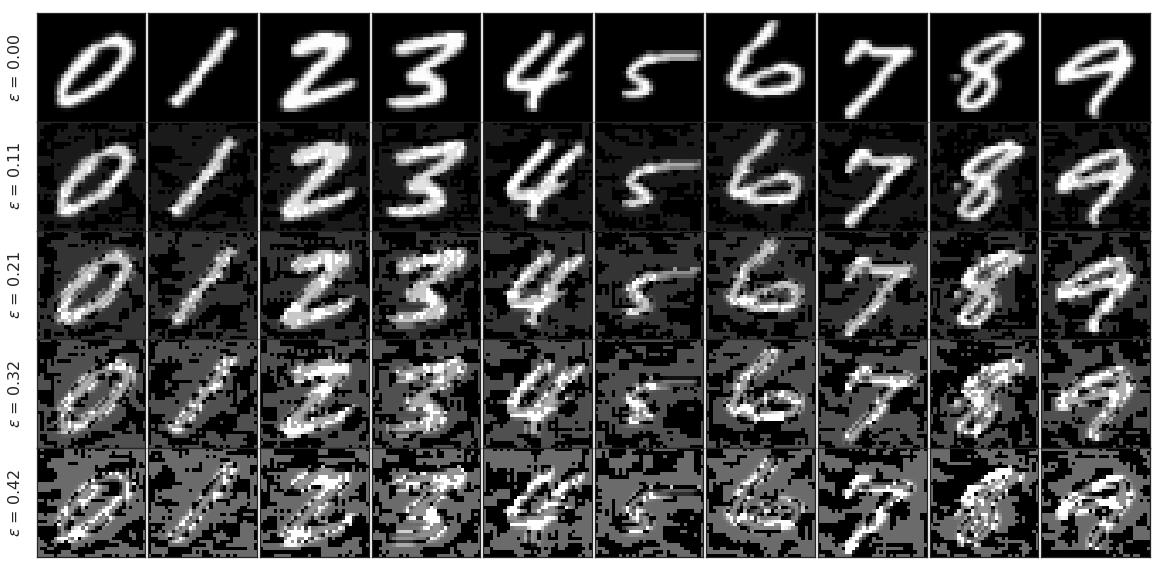

In [33]:
import matplotlib.gridspec as gridspec

nrow = 10
epsilon_size = 5
# plt.figure(figsize=(2,20))
n = epsilons.shape[0]
fig, ax_arr = plt.subplots(epsilon_size,10, figsize=(20,10))

# gs1 = gridspec.GridSpec(20, 25)
# gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for j in range(epsilon_size):
    for i in range(nrow):
        img = bayes_attack_images_arr[j*(n//epsilon_size)][i]
        img = np.squeeze(np.transpose(img, (1, 2, 0)))
        
        if dataset == 'CIFAR10':
            ax_arr[j][i].imshow(img, interpolation='nearest')
        else:
            ax_arr[j][i].imshow(img, cmap='gray', interpolation='nearest')
        
        e = epsilons[j*(n//epsilon_size)]
        if (i == 0):
            ax_arr[j][i].yaxis.set_visible(True)
            t = r'$\epsilon$ = {:.2f}'.format(e)
            ax_arr[j][i].set_ylabel(t, fontsize=16)
        else:
            ax_arr[j][i].yaxis.set_visible(False)
            
        ax_arr[j][i].xaxis.set_visible(False)
        ax_arr[j][i].set_xticklabels([])
        ax_arr[j][i].set_yticklabels([])
        

plt.subplots_adjust(wspace=0, hspace=0)

# fig.tight_layout()
plt.savefig('bayes_{}_attacks.png'.format(dataset))
plt.show()

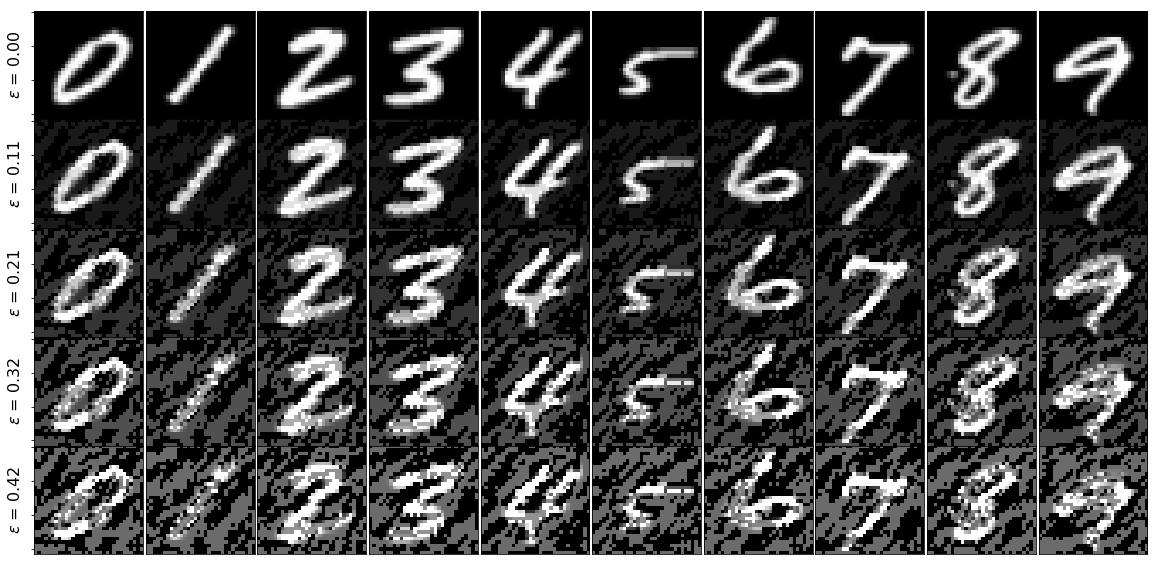

In [28]:
import matplotlib.gridspec as gridspec

nrow = 10
epsilon_size = 5
# plt.figure(figsize=(2,20))
n = epsilons.shape[0]
fig, ax_arr = plt.subplots(epsilon_size,10, figsize=(20,10))

# gs1 = gridspec.GridSpec(20, 25)
# gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for j in range(epsilon_size):
    for i in range(nrow):
        img = freq_attack_images_arr[j*(n//epsilon_size)][i]
        img = np.squeeze(np.transpose(img, (1, 2, 0)))
        
        if dataset == 'CIFAR10':
            ax_arr[j][i].imshow(img, interpolation='nearest')
        else:
            ax_arr[j][i].imshow(img, cmap='gray', interpolation='nearest')
        
        e = epsilons[j*(n//epsilon_size)]
        if (i == 0):
            ax_arr[j][i].yaxis.set_visible(True)
            t = r'$\epsilon$ = {:.2f}'.format(e)
            ax_arr[j][i].set_ylabel(t, fontsize=16)
        else:
            ax_arr[j][i].yaxis.set_visible(False)
            
        ax_arr[j][i].xaxis.set_visible(False)
        ax_arr[j][i].set_xticklabels([])
        ax_arr[j][i].set_yticklabels([])

plt.subplots_adjust(wspace=0, hspace=0)

# fig.tight_layout()
plt.savefig('freq_{}_attacks.png'.format(dataset))
plt.show()

Text(0, 0.5, 'Average predictive entropy')

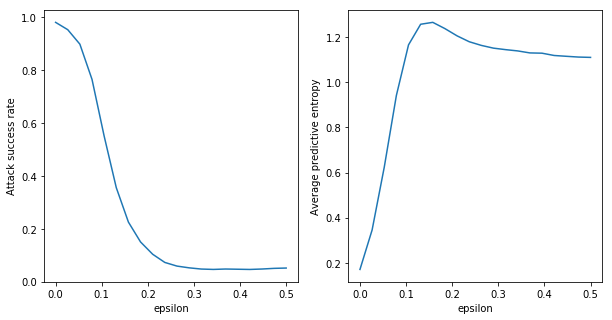

In [29]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc_bayes)
plt.xlabel('epsilon')
plt.ylabel('Attack success rate')
plt.subplot(1,2,2)
plt.plot(epsilons,entropies_bayes)
plt.xlabel('epsilon')
plt.ylabel('Average predictive entropy')

# Compare Bayes vs. non-Bayes

In [30]:
import seaborn as sns
sns.set()

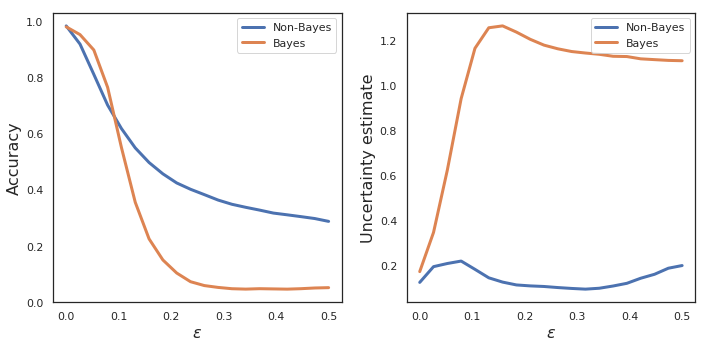

In [31]:
sns.set_style("white")
fig = plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(epsilons,acc, linewidth=3)
plt.plot(epsilons,acc_bayes, linewidth=3)
plt.legend(['Non-Bayes','Bayes'])
plt.xlabel(r'$\epsilon$', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.subplot(1,2,2)
plt.plot(epsilons,entropies, linewidth=3)
plt.plot(epsilons,entropies_bayes, linewidth=3)
plt.legend(['Non-Bayes','Bayes'])
plt.xlabel(r'$\epsilon$', fontsize=16)
plt.ylabel('Uncertainty estimate', fontsize=16)
fig.tight_layout()
plt.savefig('{}_adv_attack.png'.format(dataset))
plt.show()